# Elia OpenData Package Examples

This notebook provides practical examples of using the Elia OpenData package for common tasks.

## Imports

In [27]:
from elia_opendata import EliaDataProcessor
from elia_opendata.dataset_catalog import TOTAL_LOAD, PV_PRODUCTION, WIND_PRODUCTION, IMBALANCE_PRICES_QH_POST_MARI

from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Setup the processor

In [28]:

# Create processor with pandas output for analysis
processor = EliaDataProcessor(return_type="pandas")


## Getting Current Values

Fetch the most recent data from any dataset:

In [29]:

# Get current total load
current_load = processor.fetch_current_value(TOTAL_LOAD)
print(f"Current total load: {current_load.iloc[0]['totalload']:.2f} MW")

# Get current renewable production
current_pv = processor.fetch_current_value(PV_PRODUCTION)
current_wind = processor.fetch_current_value(WIND_PRODUCTION)
print(f"Current PV production: {current_pv.iloc[0]['measured']:.2f} MW")
print(f"Current wind production: {current_wind.iloc[0]['measured']:.2f} MW")


Current total load: 9891.24 MW
Current PV production: 0.00 MW
Current wind production: 123.43 MW
Current PV production: 0.00 MW
Current wind production: 123.43 MW


## Historical Data Analysis

Analyze patterns in electricity consumption:

Average load in June: 8554.76 MW
Peak load in June: 10920.70 MW
Minimum load in June: 6349.64 MW


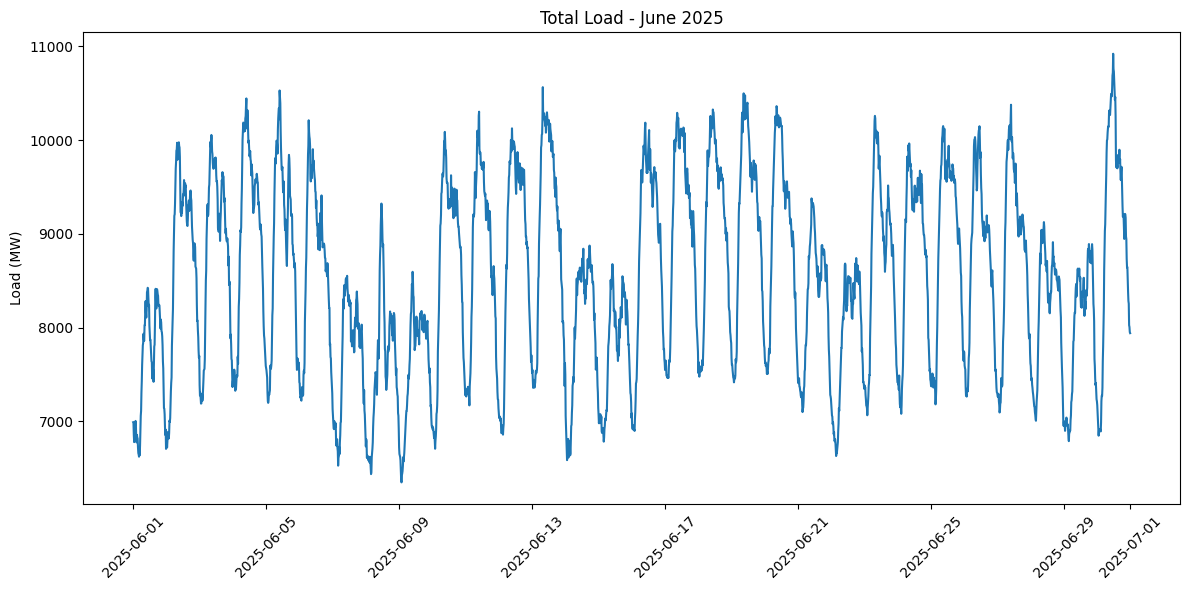

In [30]:


# Get data for a specific month
start = datetime(2025, 6, 1)
end = datetime(2025, 6, 30)

june_load = processor.fetch_data_between(dataset_id=TOTAL_LOAD, start_date=start, end_date=end, export_data=True)

# Convert datetime column and set as index
june_load['datetime'] = pd.to_datetime(june_load['datetime'])
june_load.set_index('datetime', inplace=True)
june_load.sort_index(inplace=True)


# Basic statistics
print(f"Average load in June: {june_load['totalload'].mean():.2f} MW")
print(f"Peak load in June: {june_load['totalload'].max():.2f} MW")
print(f"Minimum load in June: {june_load['totalload'].min():.2f} MW")

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(june_load.index, june_load['totalload'])
plt.title('Total Load - June 2025')
plt.ylabel('Load (MW)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Solar Production Patterns

Analyze solar production with forecasts:

In [31]:

# Get solar data for analysis
solar_data = processor.fetch_data_between(
    datetime(2025, 7, 1),
    datetime(2025, 7, 7),  # One week of data
    dataset_id=PV_PRODUCTION,
    export_data=True
)

solar_data

,datetime,resolutioncode,region,measured,mostrecentforecast,mostrecentconfidence10,mostrecentconfidence90,dayahead11hforecast,dayahead11hconfidence10,dayahead11hconfidence90,dayaheadforecast,dayaheadconfidence10,dayaheadconfidence90,weekaheadforecast,weekaheadconfidence10,weekaheadconfidence90,monitoredcapacity,loadfactor
0,2025-07-07 23:45:00+00:00,PT15M,Namur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,439.981,0.0
1,2025-07-07 23:45:00+00:00,PT15M,Flemish-Brabant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1081.578,0.0
2,2025-07-07 23:45:00+00:00,PT15M,Walloon-Brabant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,334.539,0.0
3,2025-07-07 23:45:00+00:00,PT15M,West-Flanders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1769.922,0.0
4,2025-07-07 23:45:00+00:00,PT15M,Hainaut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,993.203,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9403,2025-07-01 00:00:00+00:00,PT15M,West-Flanders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1769.922,0.0
9404,2025-07-01 00:00:00+00:00,PT15M,Brussels,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,312.409,0.0
9405,2025-07-01 00:00:00+00:00,PT15M,Hainaut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,993.203,0.0
9406,2025-07-01 00:00:00+00:00,PT15M,Liège,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,779.769,0.0


In [32]:
# Analyze the solar production data structure
print("Solar data columns:", solar_data.columns.tolist())
print(f"Total records: {len(solar_data)}")
print(f"Unique regions: {solar_data['region'].unique()}")

# Filter for measured solar production values
measured_solar = solar_data[solar_data['measured'].notna()].copy()
print(f"Measured solar production records: {len(measured_solar)}")

# Also check forecast data - using the most recent forecast
forecast_solar = solar_data[solar_data['mostrecentforecast'].notna()].copy()
print(f"Most recent forecast records: {len(forecast_solar)}")

# Convert datetime and add time components
measured_solar['datetime'] = pd.to_datetime(measured_solar['datetime'])
measured_solar['date'] = measured_solar['datetime'].dt.date
measured_solar['hour'] = measured_solar['datetime'].dt.hour

# Aggregate by date and hour to get total production across all regions
daily_totals = measured_solar.groupby('date')['measured'].sum()
print("\nDaily solar production totals (MW):")
for date, total in daily_totals.items():
    print(f"{date}: {total:.2f} MW")

# Hourly pattern analysis
hourly_avg = measured_solar.groupby('hour')['measured'].mean()
print(f"\nPeak hour for solar production: {hourly_avg.idxmax()}:00 with average {hourly_avg.max():.2f} MW")
print(f"Average daily production: {measured_solar['measured'].mean():.2f} MW per region per 15-min interval")

Solar data columns: ['datetime', 'resolutioncode', 'region', 'measured', 'mostrecentforecast', 'mostrecentconfidence10', 'mostrecentconfidence90', 'dayahead11hforecast', 'dayahead11hconfidence10', 'dayahead11hconfidence90', 'dayaheadforecast', 'dayaheadconfidence10', 'dayaheadconfidence90', 'weekaheadforecast', 'weekaheadconfidence10', 'weekaheadconfidence90', 'monitoredcapacity', 'loadfactor']
Total records: 9408
Unique regions: ['Namur' 'Flemish-Brabant' 'Walloon-Brabant' 'West-Flanders' 'Hainaut'
 'Limburg' 'Liège' 'Luxembourg' 'Antwerp' 'Belgium' 'Flanders'
 'East-Flanders' 'Wallonia' 'Brussels']
Measured solar production records: 9408
Most recent forecast records: 9408

Daily solar production totals (MW):
2025-07-01: 690871.47 MW
2025-07-02: 569234.92 MW
2025-07-03: 732926.55 MW
2025-07-04: 701476.26 MW
2025-07-05: 456827.93 MW
2025-07-06: 174396.71 MW
2025-07-07: 398086.33 MW

Peak hour for solar production: 11:00 with average 1124.43 MW
Average daily production: 395.81 MW per re

## Renewable vs Total Load Comparison

Compare renewable production with total electricity demand:

In [33]:

# Fetch all data for the same time period
start = datetime(2025, 8, 1)
end = datetime(2025, 8, 7)

total_load = processor.fetch_data_between(start, end, dataset_id=TOTAL_LOAD, export_data=True)
wind_prod = processor.fetch_data_between(start, end, dataset_id=WIND_PRODUCTION, export_data=True)
solar_prod = processor.fetch_data_between(start, end, dataset_id=PV_PRODUCTION, export_data=True)

print("Data structure check:")
print(f"Total load columns: {total_load.columns.tolist()}")
print(f"Wind production columns: {wind_prod.columns.tolist()}")
print(f"Solar production columns: {solar_prod.columns.tolist()}")

# Calculate renewable percentage using the correct column names
# For total load, use the appropriate column (likely 'totalload')
# For renewables, use 'measured' column and sum across regions
if not wind_prod.empty and not solar_prod.empty and not total_load.empty:
    # Sum renewable production across regions and time
    total_wind = wind_prod['measured'].sum()
    total_solar = solar_prod['measured'].sum()
    total_renewable = total_wind + total_solar
    
    # Sum total load (assuming 'totalload' column)
    if 'totalload' in total_load.columns:
        total_load_sum = total_load['totalload'].sum()
    else:
        # Fallback to other possible column names
        load_cols = [col for col in total_load.columns if 'load' in col.lower() or 'value' in col.lower()]
        if load_cols:
            total_load_sum = total_load[load_cols[0]].sum()
            print(f"Using column '{load_cols[0]}' for total load")
        else:
            print("Could not identify load column")
            total_load_sum = 0
    
    if total_load_sum > 0:
        renewable_percentage = (total_renewable / total_load_sum) * 100
        print(f"\nRenewable Energy Analysis:")
        print(f"Total wind production: {total_wind:.2f} MWh")
        print(f"Total solar production: {total_solar:.2f} MWh") 
        print(f"Total renewable: {total_renewable:.2f} MWh")
        print(f"Total load: {total_load_sum:.2f} MWh")
        print(f"Renewable share of total load: {renewable_percentage:.2f}%")
    else:
        print("Could not calculate renewable percentage - no load data found")

Data structure check:
Total load columns: ['datetime', 'resolutioncode', 'totalload', 'mostrecentforecast', 'mostrecentconfidence10', 'mostrecentconfidence90', 'dayaheadforecast', 'dayaheadconfidence10', 'dayaheadconfidence90', 'weekaheadforecast']
Wind production columns: ['datetime', 'resolutioncode', 'offshoreonshore', 'region', 'gridconnectiontype', 'measured', 'mostrecentforecast', 'mostrecentconfidence10', 'mostrecentconfidence90', 'dayahead11hforecast', 'dayahead11hconfidence10', 'dayahead11hconfidence90', 'dayaheadforecast', 'dayaheadconfidence10', 'dayaheadconfidence90', 'weekaheadforecast', 'weekaheadconfidence10', 'weekaheadconfidence90', 'monitoredcapacity', 'loadfactor', 'decrementalbidid']
Solar production columns: ['datetime', 'resolutioncode', 'region', 'measured', 'mostrecentforecast', 'mostrecentconfidence10', 'mostrecentconfidence90', 'dayahead11hforecast', 'dayahead11hconfidence10', 'dayahead11hconfidence90', 'dayaheadforecast', 'dayaheadconfidence10', 'dayaheadconf

## Imbalance Price Analysis

Analyze electricity market imbalance prices:

In [34]:

# Get imbalance price data
imbalance_data = processor.fetch_data_between(
    datetime(2025, 1, 1),
    datetime(2025, 2, 1),
    dataset_id=IMBALANCE_PRICES_QH_POST_MARI,
    export_data=True
)

# Basic price statistics
prices = imbalance_data['systemimbalance']  # System imbalance price
print(f"Average imbalance price: {prices.mean():.2f} €/MWh")
print(f"Price volatility (std): {prices.std():.2f} €/MWh")
print(f"Maximum price: {prices.max():.2f} €/MWh")
print(f"Minimum price: {prices.min():.2f} €/MWh")

# Price distribution analysis

positive_prices = prices[prices > 0]
negative_prices = prices[prices < 0]

print(f"Hours with positive prices: {len(positive_prices)} ({len(positive_prices)/len(prices)*100:.1f}%)")
print(f"Hours with negative prices: {len(negative_prices)} ({len(negative_prices)/len(prices)*100:.1f}%)")

Average imbalance price: -24.73 €/MWh
Price volatility (std): 152.34 €/MWh
Maximum price: 543.06 €/MWh
Minimum price: -1272.45 €/MWh
Hours with positive prices: 1434 (46.7%)
Hours with negative prices: 1638 (53.3%)


## Creating Dashboards

Simple dashboard-style analysis:

In [35]:
def energy_dashboard(date_start, date_end):
    """Create a simple energy dashboard for a date range."""
    
    processor = EliaDataProcessor(return_type="pandas")
    
    # Fetch all major datasets
    load_data = processor.fetch_data_between(date_start, date_end, dataset_id=TOTAL_LOAD, export_data=True)
    wind_data = processor.fetch_data_between(date_start, date_end, dataset_id=WIND_PRODUCTION, export_data=True)
    solar_data = processor.fetch_data_between(date_start, date_end, dataset_id=PV_PRODUCTION, export_data=True)
    
    print(f"=== Energy Dashboard: {date_start} to {date_end} ===")
    
    # Total Load Analysis
    if not load_data.empty and 'totalload' in load_data.columns:
        print(f"Total Load:")
        print(f"  Average: {load_data['totalload'].mean():.2f} MW")
        print(f"  Peak: {load_data['totalload'].max():.2f} MW")
        print(f"  Records: {len(load_data)}")
        total_load_sum = load_data['totalload'].sum()
    else:
        print("Total Load: No data available")
        total_load_sum = 0
    
    # Wind Production Analysis  
    if not wind_data.empty and 'measured' in wind_data.columns:
        wind_measured = wind_data[wind_data['measured'].notna()]
        print(f"Wind Production:")
        print(f"  Average: {wind_measured['measured'].mean():.2f} MW per region")
        print(f"  Peak: {wind_measured['measured'].max():.2f} MW")
        print(f"  Records: {len(wind_measured)}")
        total_wind = wind_measured['measured'].sum()
    else:
        print("Wind Production: No data available")
        total_wind = 0
    
    # Solar Production Analysis
    if not solar_data.empty and 'measured' in solar_data.columns:
        solar_measured = solar_data[solar_data['measured'].notna()]
        print(f"Solar Production:")
        print(f"  Average: {solar_measured['measured'].mean():.2f} MW per region")
        print(f"  Peak: {solar_measured['measured'].max():.2f} MW")
        print(f"  Records: {len(solar_measured)}")
        total_solar = solar_measured['measured'].sum()
    else:
        print("Solar Production: No data available")
        total_solar = 0
    
    # Calculate renewable share
    if total_load_sum > 0:
        total_renewable = total_wind + total_solar
        renewable_share = (total_renewable / total_load_sum) * 100
        print(f"Renewable Share: {renewable_share:.2f}%")
    else:
        print("Renewable Share: Cannot calculate (no load data)")
        
    print("=" * 50)

# Use the dashboard
energy_dashboard(datetime(2025, 7, 1), datetime(2025, 7, 7))

=== Energy Dashboard: 2025-07-01 00:00:00 to 2025-07-07 00:00:00 ===
Total Load:
  Average: 8863.74 MW
  Peak: 11538.80 MW
  Records: 672
Wind Production:
  Average: 184.00 MW per region
  Peak: 1971.37 MW
  Records: 3360
Solar Production:
  Average: 395.81 MW per region
  Peak: 7116.92 MW
  Records: 9408
Renewable Share: 72.90%


## Conclusion

These examples cover the most common use cases for the Elia OpenData package. For more specific scenarios, check the [API Reference](reference/client.md) for detailed parameter documentation.